In [1]:
# pip install pmdarima

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import pandas as pd 
from scipy.io import loadmat
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_squared_error
from math import sqrt


# The Dataset
We are using a dataset from Kaggle: Web Traffic Time Series Forecasting (https://www.kaggle.com/c/web-traffic-time-series-forecasting/data).

The training dataset consists of approximately 145k time series. Each of these time series represent a number of daily views of a different Wikipedia article, starting from July, 1st, 2015 up until December 31st, 2016. 

In [2]:
df = pd.read_csv('data/train_2.csv.zip', compression='zip')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


In [4]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [5]:
df.shape

(145063, 804)

## Preperation
For this project, we are only going to look at total volume, so we are going to sum the data for the individual page visits and work from that. Because we are looking at at the aggregate traffic, there is no reason to do row level clean-up for NaNs, missing data, etc.

In [6]:
df.loc['total_visits'] = df.sum()
df = df.iloc[[-1]]
df = df.drop('Page', axis=1)

Now let's flip the daaframe and make the datatime the index

In [7]:
df = df.T
df.index = pd.to_datetime(df.index)

Let's look at the dataframe and confirm its as expected

In [8]:
df

,total_visits
2015-07-01,148672476.0
2015-07-02,149593840.0
2015-07-03,141164198.0
2015-07-04,145612937.0
2015-07-05,151495372.0
...,...
2017-09-06,172354146.0
2017-09-07,180731284.0
2017-09-08,136754670.0
2017-09-09,132359512.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 803 entries, 2015-07-01 to 2017-09-10
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_visits  803 non-null    float64
dtypes: float64(1)
memory usage: 12.5 KB


Let's split and plot the data

In [10]:
y_hist = df.loc['2015-07-01':'2017-03-31']
y_future = df.loc['2017-04-01':'2017-09-10']
h = len(y_hist)
f = len(y_future)

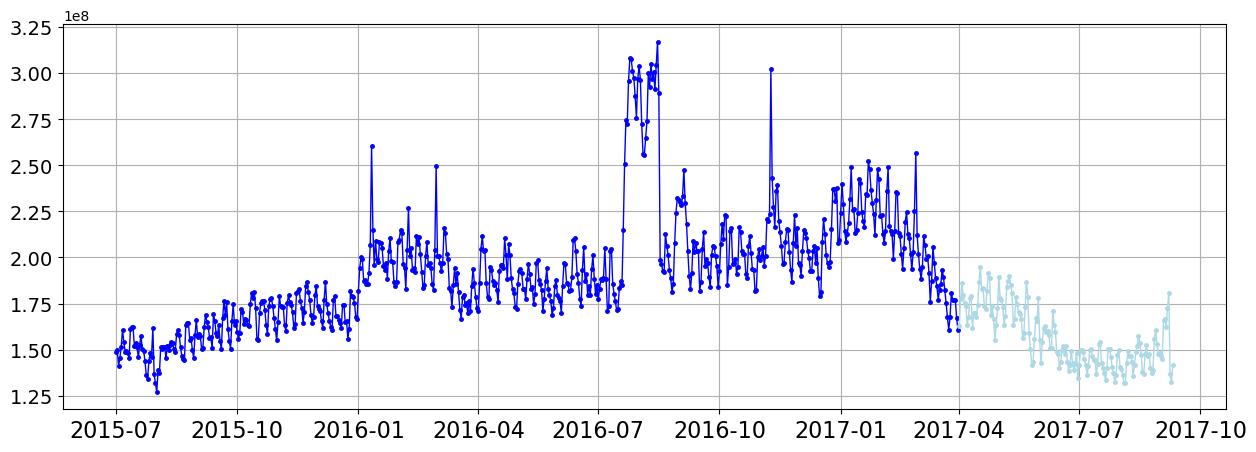

In [11]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot() # nrows, ncols, index

plt.plot(y_hist,'.-',
         markerfacecolor='blue',
         markersize=5,
         linewidth=1,
         color='blue')
plt.plot(y_future,'.-',
         markerfacecolor='lightblue',
         markersize=5,
         linewidth=1,
         color='lightblue')

plt.grid()
plt.ylabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=16)
#plt.xlim((6000, 19000))

myylim = plt.ylim()

<Axes: ylabel='Density'>

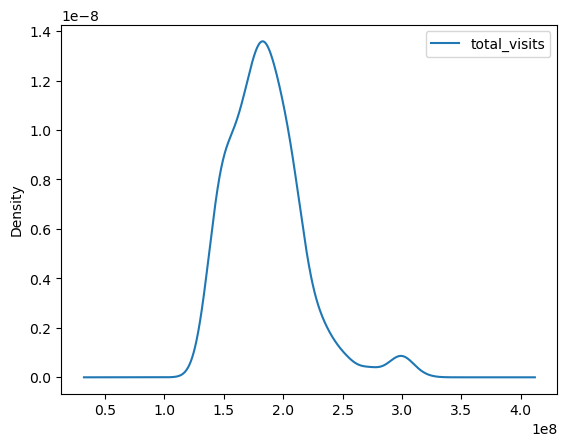

In [12]:
df.plot.kde()

<Axes: ylabel='total_visits'>

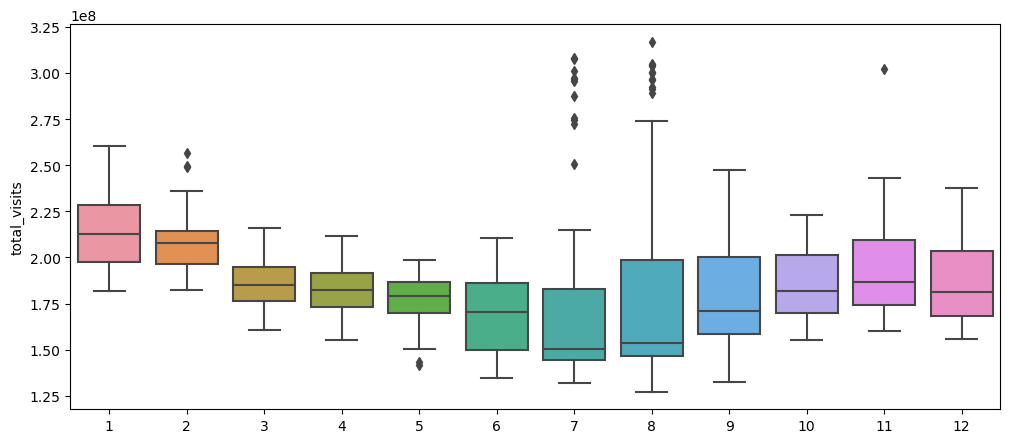

In [13]:
fig, ax = plt.subplots(figsize=(12,5))
seaborn.boxplot(x = df.index.month,
                y = df['total_visits'], 
                ax = ax)

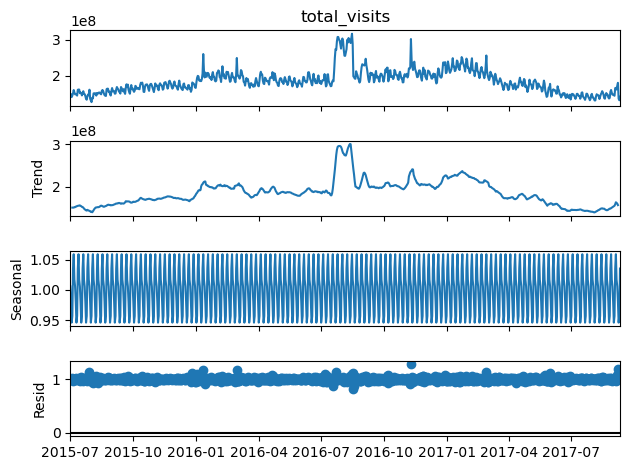

In [14]:
seasonal_decomp = seasonal_decompose(df['total_visits'], model="multiplicative")
seasonal_decomp.plot();

There does not appear to be an seasonality in the data, there also don't seem to be any patterns in the residuals.

Check if it is stationary

In [15]:
dftest = adfuller(df, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression:", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)    

1. ADF :  -2.6545675105828077
2. P-Value :  0.0822353765349838
3. Num Of Lags :  21
4. Num Of Observations Used For ADF Regression: 781
5. Critical Values :
	 1% :  -3.438750669890019
	 5% :  -2.8652477937238703
	 10% :  -2.56874438754281


p > 0.05 is technically not stationary, but it is really close.


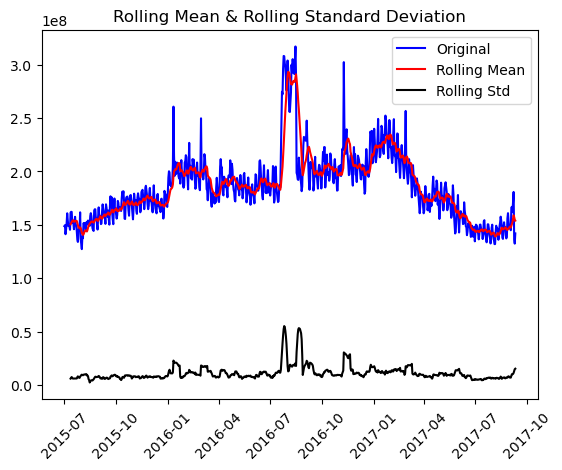

In [16]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.xticks(rotation=45)
plt.show()

STD is pretty flat, but the rolling mean is not.

# Develop Model

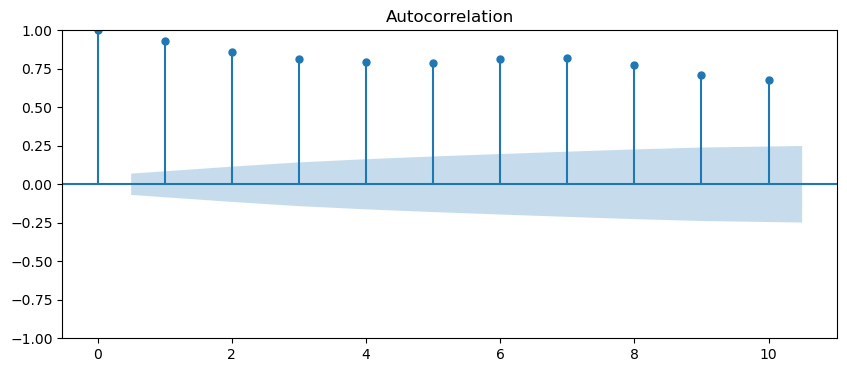

In [17]:
fig, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(df,lags=10, ax=ax)
plt.show()

In [18]:
y_hist_diff = y_hist.diff()

<Axes: >

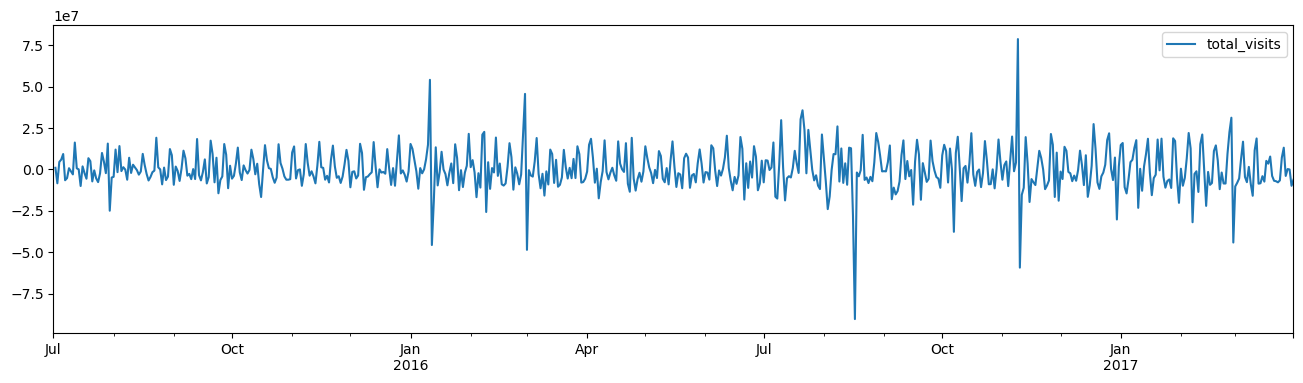

In [19]:
y_hist_diff.plot(figsize=(16,4))

In [20]:
stepwise_fit = auto_arima(df['total_visits'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28379.933, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28380.623, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28379.802, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28377.934, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28343.991, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28305.316, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28342.436, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=28306.816, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28311.055, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=28332.929, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=28312.376, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=28303.306, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=28341.985, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]  

In [21]:
model = ARIMA(df['total_visits'], order=(1,0,5))
model = model.fit()
model.summary()

/Users/osultan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/osultan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/osultan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           total_visits   No. Observations:                  803
Model:                 ARIMA(1, 0, 5)   Log Likelihood              -14155.101
Date:                Tue, 20 Feb 2024   AIC                          28326.202
Time:                        18:47:01   BIC                          28363.709
Sample:                    07-01-2015   HQIC                         28340.608
                         - 09-10-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.855e+08    9.5e-12   1.95e+19      0.000    1.85e+08    1.85e+08
ar.L1          0.9883      0.006    165.447      0.000       0.977       1.000
ma.L1         -0.0095      0.021     -0.460      0.645      -0.050       0.031
ma.L2         -0.2054      0.035     -5.868      0.000      -0.274      -0.137
ma.L3         -0.1256      0.035     -3.600      0.000      -0.194      -0.057
ma.L4         -0.0899      0.036     -2.509      0.012      -0.160      -0.020
ma.L5         -0.1543      0.035     -4.459      0.000      -0.222      -0.086
sigma2      1.302e+14   1.73e-16   7.52e+29      0.000     1.3e+14     1.3e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              3161.59
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.12
Prob(H) (two-sided):                  0.80   Kurtosis:                        12.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.33e+44. Standard errors may be unstable.
"""

<Axes: >

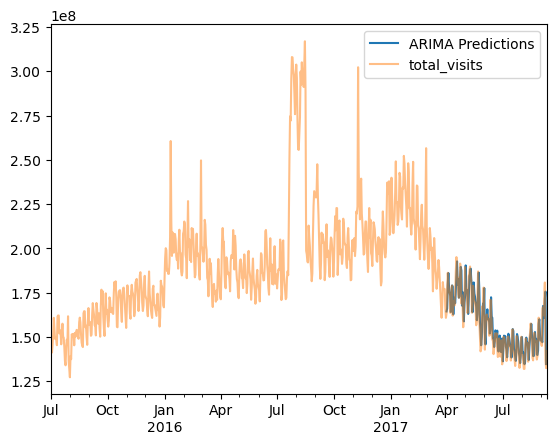

In [22]:
start = len(y_hist)
end = start + len(y_future) - 1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
df['total_visits'].plot(legend=True, alpha=0.5)

In [23]:
y_future['total_visits'].mean()
rmse=sqrt(mean_squared_error(pred,y_future['total_visits']))
print(rmse)

7755639.524684531
